# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pip install librosa

In [ ]:
import os
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
import librosa as lr
import soundfile as sf
import scipy.signal as sig
from random import random, randint, shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier





# Global Code

In [ ]:
dataset_dir = '/content/drive/MyDrive/iit_our_rec/'
ambient_path = '/content/drive/MyDrive/iit_our_rec/noise_44min.wav'

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_name):
    if model_name == 'SVM':
        model = SVC(C=10, kernel='rbf', gamma='scale')
    elif model_name == 'Random Forest':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_name == 'Naive Bayes':
        model = GaussianNB()
    elif model_name == 'Decision Trees':
        model = DecisionTreeClassifier(random_state=42)
    elif model_name == 'k-Nearest Neighbors':
        model = KNeighborsClassifier(n_neighbors=5)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion_mat = confusion_matrix(y_test, y_pred)

    print("Model:", model_name)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(confusion_mat)
    print("\n")

    # Plotting confusion matrix as an image
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set(xticks=np.arange(confusion_mat.shape[1]),
           yticks=np.arange(confusion_mat.shape[0]),
           xticklabels=['Class 0', 'Class 1', 'Class 2'],
           yticklabels=['Class 0', 'Class 1', 'Class 2'],
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(confusion_mat.shape[0]):
        for j in range(confusion_mat.shape[1]):
            ax.text(j, i, format(confusion_mat[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if confusion_mat[i, j] > confusion_mat.max() / 2. else "black")

    fig.tight_layout()
    plt.show()


In [ ]:
model_names = ['SVM', 'Random Forest', 'Naive Bayes', 'Decision Trees', 'k-Nearest Neighbors']


# Mel

In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf

def mix_audio(main_folder_path, file_path_ambient, duration, SR, Limit):
    audio_data = []
    mel_spec_data = []
    labels = []

    segment_sr_required = duration * SR

    no_of_drone_samples = 0
    no_of_swarm_drone_samples = 0
    no_of_aircraft_samples = 0

    for file_name in os.listdir(main_folder_path):
        if 'drone'.lower() in file_name.lower():
            flag = 0
        elif 'swarm'.lower() in file_name.lower():
            flag = 1
        elif 'aircraft'.lower() in file_name.lower():
            flag = 2
        else:
            continue

        if file_name.endswith('.wav') or file_name.endswith('.WAV') or file_name.endswith('.mp3'):
            file_path = os.path.join(main_folder_path, file_name)
            signal_data, sr = librosa.load(file_path, sr=None, duration=1747)
            signal_data = signal_data / np.max(np.abs(signal_data))
            noise_data, sr_noise = librosa.load(file_path_ambient, sr=None, duration=2640)
            noise_data = noise_data / np.max(np.abs(noise_data))

            s = len(signal_data)
            n = len(noise_data)

            if n > s:
                noise_data = noise_data[0:s]
            elif s > n:
                w = s - n
                noise_data = np.concatenate((noise_data, noise_data[0:w]))
            else:
                pass

            N = int(len(signal_data) / segment_sr_required)

            for i in range(N):
                start = i * segment_sr_required
                end = start + segment_sr_required

                if end - start != SR:
                    continue

                segment = signal_data[start:end]
                start_noise = np.random.randint(0, N-1) * segment_sr_required
                end_noise = start_noise + segment_sr_required

                if end_noise - start_noise != SR:
                    continue

                noise = noise_data[start_noise:end_noise]

                rms_signal = np.mean(np.square(segment))
                rms_noise = np.mean(np.square(noise))

                dbset = [-25, -20, -15, -10, -5, 0, 5, 10, 15, 20]

                for j in range(len(dbset)):
                    rms_signal_req_to_increase = rms_noise / (10 ** (-dbset[j] / 10))
                    scaling_factor = np.sqrt(rms_signal_req_to_increase / rms_signal)
                    adjusted_audio_signal = segment * scaling_factor

                    adjusted_audio_signal += noise

                    audio_data.append(adjusted_audio_signal)

                    segment_mel_spec = librosa.feature.melspectrogram(y=adjusted_audio_signal, sr=SR, n_fft=2048*2, hop_length=512, win_length=1024, n_mels=256)
                    mean_of_mel = np.mean(segment_mel_spec, axis=-1)

                    mel_spec_data.append(mean_of_mel)
                    labels.append(flag)

                    if flag == 0:
                        no_of_drone_samples += 1
                    elif flag == 1:
                        no_of_swarm_drone_samples += 1
                    elif flag == 2:
                        no_of_aircraft_samples += 1

    # audio_data = tf.keras.preprocessing.sequence.pad_sequences(audio_data)
    mel_spec_data = tf.keras.preprocessing.sequence.pad_sequences(mel_spec_data)
    labels = tf.keras.utils.to_categorical(labels, num_classes=3)

    # mean_audio = np.mean(audio_data)
    # std_audio = np.std(audio_data)
    # normalized_audio_data = (audio_data - mean_audio) / std_audio

    mean_mel_spec = np.mean(mel_spec_data)
    std_mel_spec = np.std(mel_spec_data)
    normalized_mel_spec_data = (mel_spec_data - mean_mel_spec) / std_mel_spec

    print("Drone samples:", no_of_drone_samples,
          "\nSwarm Drone samples:", no_of_swarm_drone_samples
          ,"\nAircraft samples:", no_of_aircraft_samples)

    return normalized_mel_spec_data, labels


In [ ]:
mel_data, labels = mix_audio(dataset_dir, ambient_path, 1, 44100, 21000)

# Convert one-hot encoded labels to 1D array
y_labels = np.argmax(labels, axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mel_data, y_labels, test_size=0.3, random_state=42)


Drone samples: 17470 
Swarm Drone samples: 17470 
Aircraft samples: 17470


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

# Create SVM classifiers with different kernels
classifiers = {
    'Linear': SVC(kernel='linear'),
    'Cubic': SVC(kernel='poly', degree=3),
    'Quadratic': SVC(kernel='poly', degree=2),
    'Gaussian': SVC(kernel='rbf'),
}

# Define class labels
class_labels = ['Drone', 'Swarm Drone', 'Aircraft']

# Train and evaluate each SVM classifier
for kernel_name, classifier in classifiers.items():
    # Train the classifier
    classifier.fit(X_train, y_train)

    # Predict labels for test set
    y_pred = classifier.predict(X_test)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate sensitivity, specificity, and class-wise accuracy
    sensitivity = []
    specificity = []
    class_accuracy = []
    for i in range(len(class_labels)):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - tp - fn - fp

        class_sensitivity = tp / (tp + fn)
        class_specificity = tn / (tn + fp)
        class_samples = np.sum(y_test == i)
        class_correct = tp
        class_acc = class_correct / class_samples

        sensitivity.append(class_sensitivity)
        specificity.append(class_specificity)
        class_accuracy.append(class_acc)

    # Print confusion matrix
    print(f'{kernel_name} kernel:')
    print('Confusion Matrix:')
    print(cm)
    print()

    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=class_labels)

    # Print classification report
    print('Classification Report:')
    print(report)
    print()

    # Print class-wise metrics
    print('Class-wise Metrics:')
    for i, label in enumerate(class_labels):
        print(f'{label}:')
        print(f'  Sensitivity: {sensitivity[i]}')
        print(f'  Specificity: {specificity[i]}')
        print(f'  Accuracy: {class_accuracy[i]}')
        print()


Linear kernel:
Confusion Matrix:
[[4575  464  164]
 [2028 3097  167]
 [2423  539 2266]]

Classification Report:
              precision    recall  f1-score   support

       Drone       0.51      0.88      0.64      5203
 Swarm Drone       0.76      0.59      0.66      5292
    Aircraft       0.87      0.43      0.58      5228

    accuracy                           0.63     15723
   macro avg       0.71      0.63      0.63     15723
weighted avg       0.71      0.63      0.63     15723


Class-wise Metrics:
Drone:
  Sensitivity: 0.8793004036133
  Specificity: 0.5769011406844107
  Accuracy: 0.8793004036133

Swarm Drone:
  Sensitivity: 0.5852229780801209
  Specificity: 0.9038443102291247
  Accuracy: 0.5852229780801209

Aircraft:
  Sensitivity: 0.4334353481254782
  Specificity: 0.9684611719866603
  Accuracy: 0.4334353481254782

Cubic kernel:
Confusion Matrix:
[[5189    0   14]
 [4713  577    2]
 [4672    1  555]]

Classification Report:
              precision    recall  f1-score   suppo

Model: SVM
Accuracy: 0.614768174012593
Precision: 0.6785616810492953
Recall: 0.614768174012593
F1 Score: 0.6043778398234786
Confusion Matrix:
[[3088 1960  180]
 [ 515 4552  225]
 [ 886 2291 2026]]




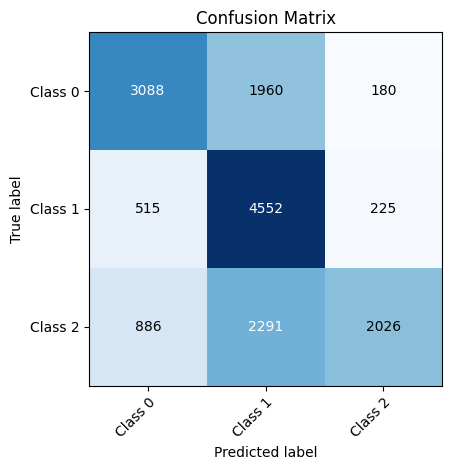

Model: SVM
-------------------------------------
Model: Random Forest
Accuracy: 0.8863448451313363
Precision: 0.8864495191230013
Recall: 0.8863448451313363
F1 Score: 0.8862692555060624
Confusion Matrix:
[[4724  237  267]
 [ 249 4733  310]
 [ 416  308 4479]]




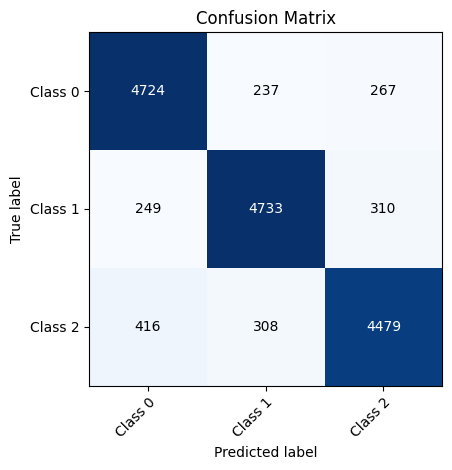

Model: Random Forest
-------------------------------------
Model: Naive Bayes
Accuracy: 0.4474972969535076
Precision: 0.7710621301514967
Recall: 0.4474972969535076
F1 Score: 0.3820407164084712
Confusion Matrix:
[[1069    0 4159]
 [   0  824 4468]
 [  21   39 5143]]




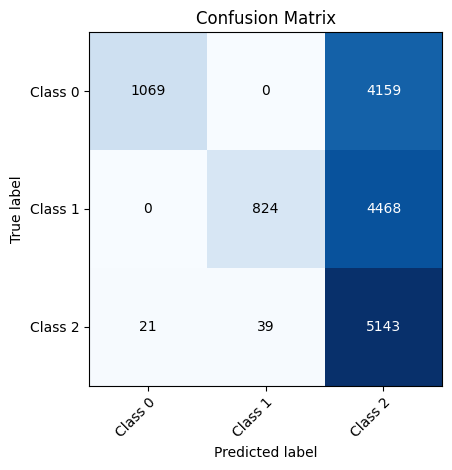

Model: Naive Bayes
-------------------------------------
Model: Decision Trees
Accuracy: 0.8237613686955416
Precision: 0.8236480101265607
Recall: 0.8237613686955416
F1 Score: 0.8235827663783237
Confusion Matrix:
[[4429  323  476]
 [ 376 4433  483]
 [ 582  531 4090]]




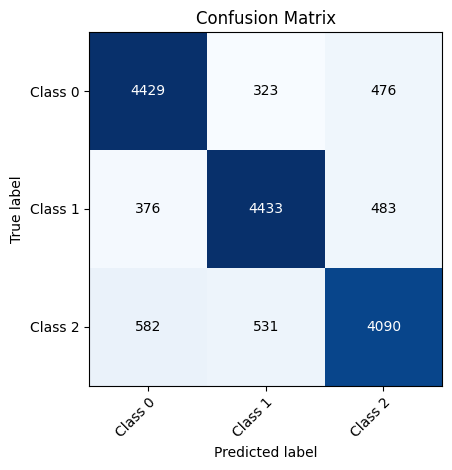

Model: Decision Trees
-------------------------------------
Model: k-Nearest Neighbors
Accuracy: 0.7906887998473574
Precision: 0.7952133313792519
Recall: 0.7906887998473574
F1 Score: 0.7902643945525496
Confusion Matrix:
[[4443  401  384]
 [ 649 4261  382]
 [ 926  549 3728]]




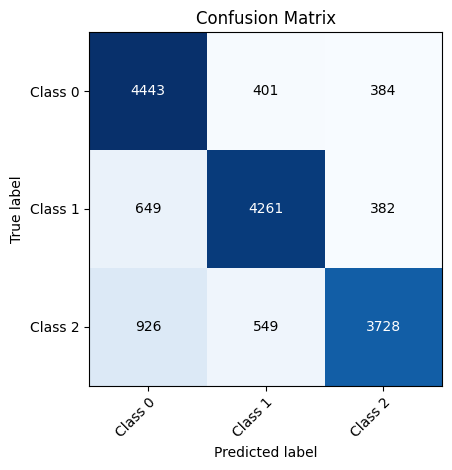

Model: k-Nearest Neighbors
-------------------------------------


In [ ]:
for model_name in model_names:
    train_and_evaluate_model(X_train, y_train, X_test, y_test, model_name)
    print("Model:", model_name)
    print("-------------------------------------")

20% testing

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mel_data, y_labels, test_size=0.2, random_state=42)

Model: SVM
Accuracy: 0.6141957641671437
Precision: 0.6821380061579073
Recall: 0.6141957641671437
F1 Score: 0.6037434179548462
Confusion Matrix:
[[2044 1358  124]
 [ 294 3045  147]
 [ 571 1550 1349]]




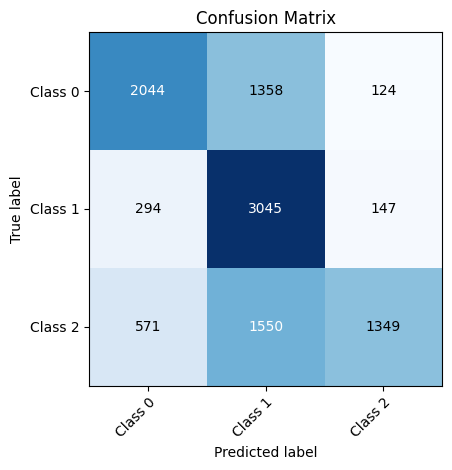

Model: SVM
-------------------------------------
Model: Random Forest
Accuracy: 0.8965846212554855
Precision: 0.8967053502408465
Recall: 0.8965846212554855
F1 Score: 0.8964986602553416
Confusion Matrix:
[[3223  139  164]
 [ 154 3156  176]
 [ 257  194 3019]]




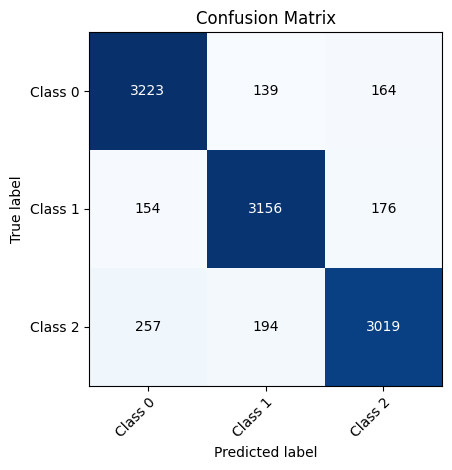

Model: Random Forest
-------------------------------------
Model: Naive Bayes
Accuracy: 0.44514405647777144
Precision: 0.7685757019875775
Recall: 0.44514405647777144
F1 Score: 0.37839403777021324
Confusion Matrix:
[[ 711    0 2815]
 [   0  527 2959]
 [  10   32 3428]]




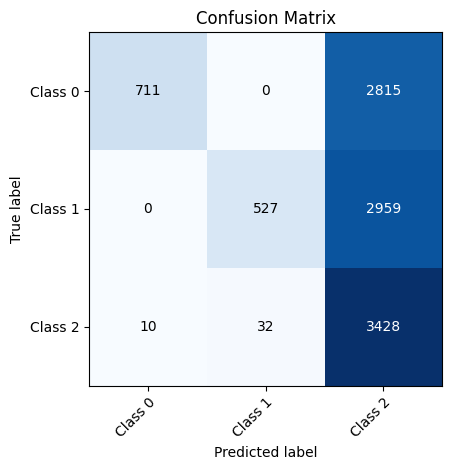

Model: Naive Bayes
-------------------------------------
Model: Decision Trees
Accuracy: 0.8298034726197291
Precision: 0.8296455235020238
Recall: 0.8298034726197291
F1 Score: 0.8296488677211646
Confusion Matrix:
[[3001  195  330]
 [ 239 2944  303]
 [ 366  351 2753]]




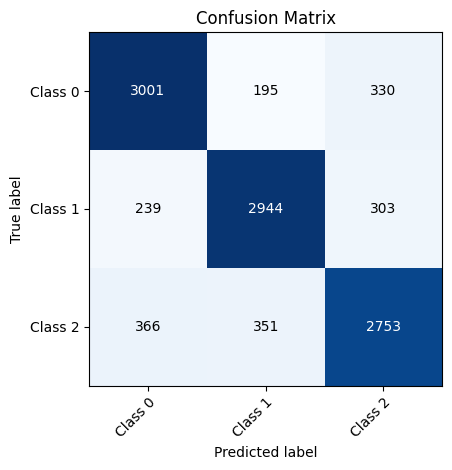

Model: Decision Trees
-------------------------------------
Model: k-Nearest Neighbors
Accuracy: 0.8018507918336195
Precision: 0.8058185470064394
Recall: 0.8018507918336195
F1 Score: 0.8012768894963342
Confusion Matrix:
[[3040  249  237]
 [ 399 2845  242]
 [ 584  366 2520]]




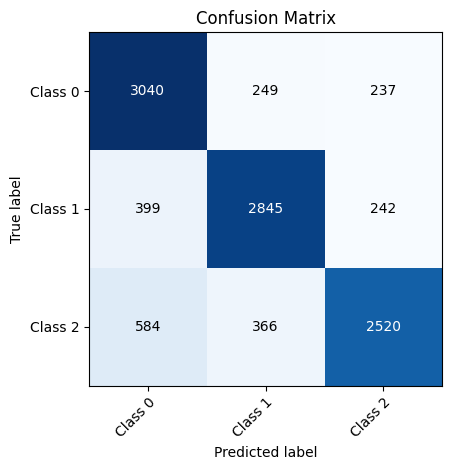

Model: k-Nearest Neighbors
-------------------------------------


In [ ]:
for model_name in model_names:
    train_and_evaluate_model(X_train, y_train, X_test, y_test, model_name)
    print("Model:", model_name)
    print("-------------------------------------")

# Mfcc

In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf

def mix_audio(main_folder_path, file_path_ambient, duration, SR, Limit):
    audio_data = []
    mel_spec_data = []
    labels = []

    segment_sr_required = duration * SR

    no_of_drone_samples = 0
    no_of_swarm_drone_samples = 0
    no_of_aircraft_samples = 0

    for file_name in os.listdir(main_folder_path):
        if 'drone'.lower() in file_name.lower():
            flag = 0
        elif 'swarm'.lower() in file_name.lower():
            flag = 1
        elif 'aircraft'.lower() in file_name.lower():
            flag = 2
        else:
            continue

        if file_name.endswith('.wav') or file_name.endswith('.WAV') or file_name.endswith('.mp3'):
            file_path = os.path.join(main_folder_path, file_name)
            signal_data, sr = librosa.load(file_path, sr=None, duration=1747)
            signal_data = signal_data / np.max(np.abs(signal_data))
            noise_data, sr_noise = librosa.load(file_path_ambient, sr=None, duration=2640)
            noise_data = noise_data / np.max(np.abs(noise_data))

            s = len(signal_data)
            n = len(noise_data)

            if n > s:
                noise_data = noise_data[0:s]
            elif s > n:
                w = s - n
                noise_data = np.concatenate((noise_data, noise_data[0:w]))
            else:
                pass

            N = int(len(signal_data) / segment_sr_required)

            for i in range(N):
                start = i * segment_sr_required
                end = start + segment_sr_required

                if end - start != SR:
                    continue

                segment = signal_data[start:end]
                start_noise = np.random.randint(0, N-1) * segment_sr_required
                end_noise = start_noise + segment_sr_required

                if end_noise - start_noise != SR:
                    continue

                noise = noise_data[start_noise:end_noise]

                rms_signal = np.mean(np.square(segment))
                rms_noise = np.mean(np.square(noise))

                dbset = [-25, -20, -15, -10, -5, 0, 5, 10, 15, 20]

                for j in range(len(dbset)):
                    rms_signal_req_to_increase = rms_noise / (10 ** (-dbset[j] / 10))
                    scaling_factor = np.sqrt(rms_signal_req_to_increase / rms_signal)
                    adjusted_audio_signal = segment * scaling_factor

                    adjusted_audio_signal += noise

                    audio_data.append(adjusted_audio_signal)

                    mfcc = librosa.feature.mfcc(y=adjusted_audio_signal, sr=SR, n_mfcc=23)
                    mean_mfcc = np.mean(mfcc, axis=-1)

                    mel_spec_data.append(mean_mfcc)
                    labels.append(flag)

                    if flag == 0:
                        no_of_drone_samples += 1
                    elif flag == 1:
                        no_of_swarm_drone_samples += 1
                    elif flag == 2:
                        no_of_aircraft_samples += 1

    mel_spec_data = tf.keras.preprocessing.sequence.pad_sequences(mel_spec_data)
    labels = tf.keras.utils.to_categorical(labels, num_classes=3)

    mean_mel_spec = np.mean(mel_spec_data)
    std_mel_spec = np.std(mel_spec_data)
    normalized_mel_spec_data = (mel_spec_data - mean_mel_spec) / std_mel_spec

    print("Drone samples:", no_of_drone_samples,
          "\nSwarm Drone samples:", no_of_swarm_drone_samples
          ,"\nAircraft samples:", no_of_aircraft_samples)

    return normalized_mel_spec_data, labels


In [ ]:
mfcc_data, labels_mfcc = mix_audio(dataset_dir, ambient_path, 1, 44100, 21000)
# Convert one-hot encoded labels to 1D array
y_labels = np.argmax(labels_mfcc, axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mfcc_data, y_labels, test_size=0.3, random_state=42)


Drone samples: 17470 
Swarm Drone samples: 17470 
Aircraft samples: 17470


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

# Create SVM classifiers with different kernels
classifiers = {
    'Linear': SVC(kernel='linear'),
    'Cubic': SVC(kernel='poly', degree=3),
    'Quadratic': SVC(kernel='poly', degree=2),
    'Gaussian': SVC(kernel='rbf'),
}

# Define class labels
class_labels = ['Drone', 'Swarm Drone', 'Aircraft']

# Train and evaluate each SVM classifier
for kernel_name, classifier in classifiers.items():
    # Train the classifier
    classifier.fit(X_train, y_train)

    # Predict labels for test set
    y_pred = classifier.predict(X_test)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate sensitivity, specificity, and class-wise accuracy
    sensitivity = []
    specificity = []
    class_accuracy = []
    for i in range(len(class_labels)):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - tp - fn - fp

        class_sensitivity = tp / (tp + fn)
        class_specificity = tn / (tn + fp)
        class_samples = np.sum(y_test == i)
        class_correct = tp
        class_acc = class_correct / class_samples

        sensitivity.append(class_sensitivity)
        specificity.append(class_specificity)
        class_accuracy.append(class_acc)

    # Print confusion matrix
    print(f'{kernel_name} kernel:')
    print('Confusion Matrix:')
    print(cm)
    print()

    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=class_labels)

    # Print classification report
    print('Classification Report:')
    print(report)
    print()

    # Print class-wise metrics
    print('Class-wise Metrics:')
    for i, label in enumerate(class_labels):
        print(f'{label}:')
        print(f'  Sensitivity: {sensitivity[i]}')
        print(f'  Specificity: {specificity[i]}')
        print(f'  Accuracy: {class_accuracy[i]}')
        print()


Linear kernel:
Confusion Matrix:
[[4885   59  259]
 [  54 4508  730]
 [ 118  617 4493]]

Classification Report:
              precision    recall  f1-score   support

       Drone       0.97      0.94      0.95      5203
 Swarm Drone       0.87      0.85      0.86      5292
    Aircraft       0.82      0.86      0.84      5228

    accuracy                           0.88     15723
   macro avg       0.89      0.88      0.88     15723
weighted avg       0.88      0.88      0.88     15723


Class-wise Metrics:
Drone:
  Sensitivity: 0.9388814145685181
  Specificity: 0.9836501901140684
  Accuracy: 0.9388814145685181

Swarm Drone:
  Sensitivity: 0.8518518518518519
  Specificity: 0.9351931741923114
  Accuracy: 0.8518518518518519

Aircraft:
  Sensitivity: 0.8594108645753634
  Specificity: 0.9057646498332539
  Accuracy: 0.8594108645753634

Cubic kernel:
Confusion Matrix:
[[5015   64  124]
 [   3 4849  440]
 [  35  527 4666]]

Classification Report:
              precision    recall  f1-score  

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def check_overfitting(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))

    train_loss = model.score(X_train, y_train)
    test_loss = model.score(X_test, y_test)

    train_precision = precision_score(y_train, model.predict(X_train), average='weighted')
    test_precision = precision_score(y_test, model.predict(X_test), average='weighted')

    train_recall = recall_score(y_train, model.predict(X_train), average='weighted')
    test_recall = recall_score(y_test, model.predict(X_test), average='weighted')

    train_f1 = f1_score(y_train, model.predict(X_train), average='weighted')
    test_f1 = f1_score(y_test, model.predict(X_test), average='weighted')

    confusion_mat = confusion_matrix(y_test, model.predict(X_test))

    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

    print("Train Loss:", train_loss)
    print("Test Loss:", test_loss)

    print("Train Precision:", train_precision)
    print("Test Precision:", test_precision)

    print("Train Recall:", train_recall)
    print("Test Recall:", test_recall)

    print("Train F1:", train_f1)
    print("Test F1:", test_f1)

    print("Confusion Matrix:")
    print(confusion_mat)

if __name__ == "__main__":
    model = SVC(C=10, kernel='rbf', gamma='scale')
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)

    check_overfitting(model, X_train, X_test, y_train, y_test)


Train Accuracy: 0.9276206322795341
Test Accuracy: 0.927478376580173
Train Loss: 0.9276206322795341
Test Loss: 0.927478376580173
Train Precision: 0.9289462500376956
Test Precision: 0.9284644897802512
Train Recall: 0.9276206322795341
Test Recall: 0.927478376580173
Train F1: 0.9279014716873146
Test F1: 0.9277839573171216
Confusion Matrix:
[[971  10  22]
 [  1 875 102]
 [  8  75 942]]


Model: SVM
Accuracy: 0.9355720918399797
Precision: 0.9361479270803742
Recall: 0.9355720918399797
F1 Score: 0.9357901225829128
Confusion Matrix:
[[5092   31  105]
 [   6 4840  446]
 [  44  381 4778]]




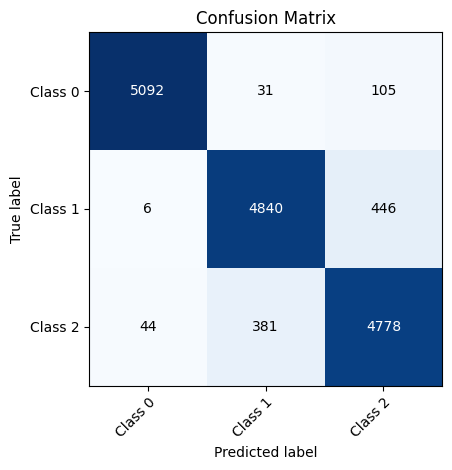

Model: SVM
-------------------------------------
Model: Random Forest
Accuracy: 0.9715067099154105
Precision: 0.9718843883460649
Recall: 0.9715067099154105
F1 Score: 0.9715774984698771
Confusion Matrix:
[[5168    9   51]
 [   0 5043  249]
 [  11  128 5064]]




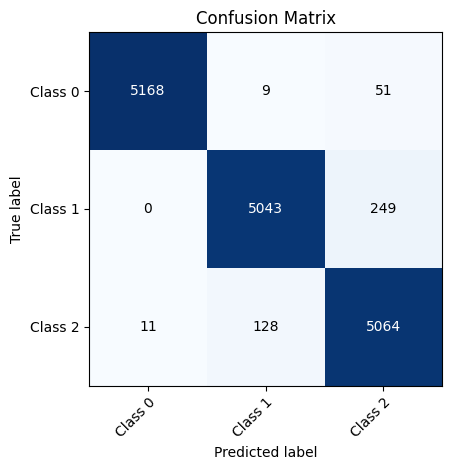

Model: Random Forest
-------------------------------------
Model: Naive Bayes
Accuracy: 0.7502385041022706
Precision: 0.7778835880218394
Recall: 0.7502385041022706
F1 Score: 0.7540205756048071
Confusion Matrix:
[[4255  198  775]
 [  26 3279 1987]
 [ 241  700 4262]]




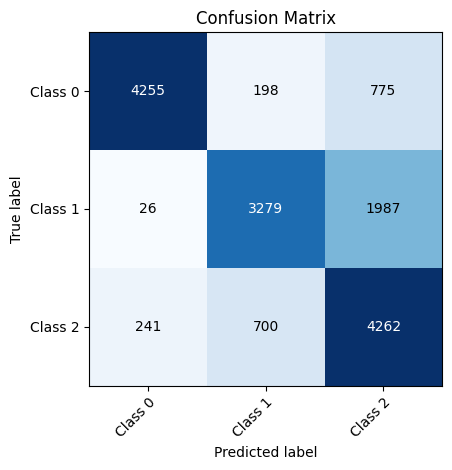

Model: Naive Bayes
-------------------------------------
Model: Decision Trees
Accuracy: 0.9234878839916046
Precision: 0.92346962734686
Recall: 0.9234878839916046
F1 Score: 0.9234780771251629
Confusion Matrix:
[[5060   42  126]
 [  53 4817  422]
 [ 117  443 4643]]




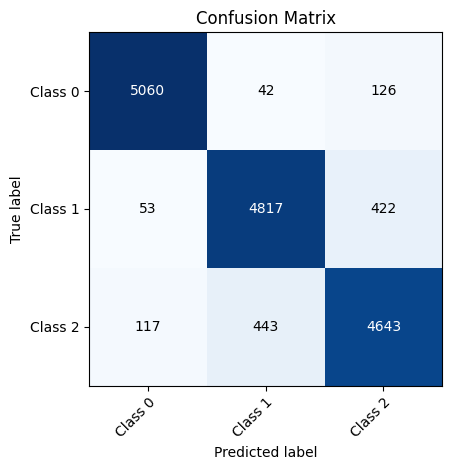

Model: Decision Trees
-------------------------------------
Model: k-Nearest Neighbors
Accuracy: 0.9487375182853145
Precision: 0.948751437050893
Recall: 0.9487375182853145
F1 Score: 0.9486978253572127
Confusion Matrix:
[[5166   24   38]
 [  13 4980  299]
 [  58  374 4771]]




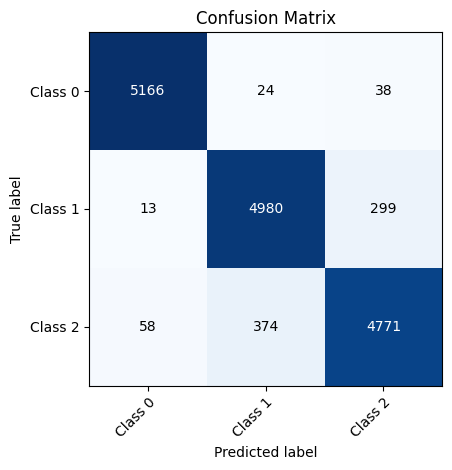

Model: k-Nearest Neighbors
-------------------------------------


In [ ]:
for model_name in model_names:
    train_and_evaluate_model(X_train, y_train, X_test, y_test, model_name)
    print("Model:", model_name)
    print("-------------------------------------")

20% testing

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mfcc_data, y_labels, test_size=0.2, random_state=42)


Model: SVM
Accuracy: 0.9383705399732876
Precision: 0.9388241847254397
Recall: 0.9383705399732876
F1 Score: 0.9385550789582285
Confusion Matrix:
[[3441   22   63]
 [   5 3204  277]
 [  27  252 3191]]




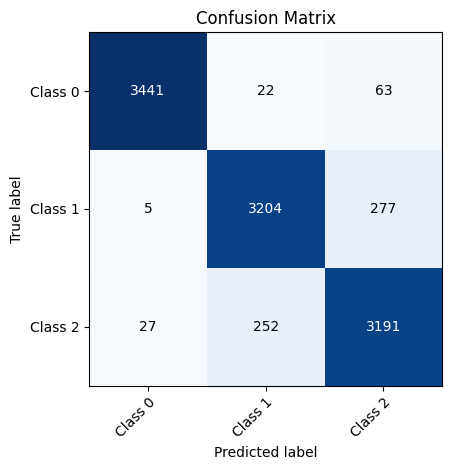

Model: SVM
-------------------------------------
Model: Random Forest
Accuracy: 0.973573745468422
Precision: 0.9738230866391392
Recall: 0.973573745468422
F1 Score: 0.9736401151029458
Confusion Matrix:
[[3484    6   36]
 [   0 3348  138]
 [   4   93 3373]]




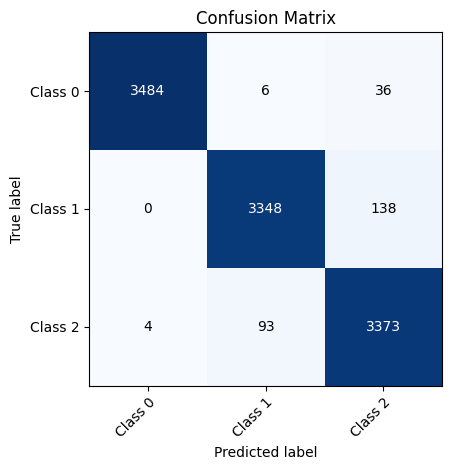

Model: Random Forest
-------------------------------------
Model: Naive Bayes
Accuracy: 0.7492844876931883
Precision: 0.77720860999175
Recall: 0.7492844876931883
F1 Score: 0.7530510822359027
Confusion Matrix:
[[2870  135  521]
 [  14 2141 1331]
 [ 159  468 2843]]




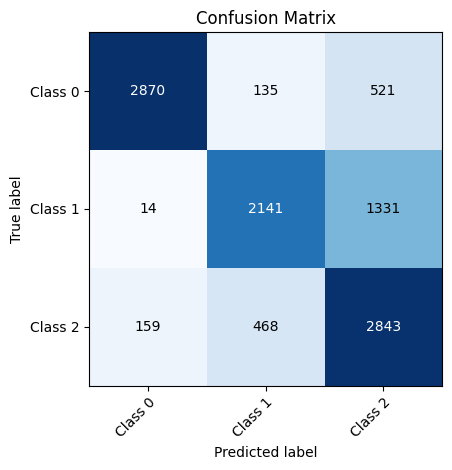

Model: Naive Bayes
-------------------------------------
Model: Decision Trees
Accuracy: 0.930929211982446
Precision: 0.9307979047285139
Recall: 0.930929211982446
F1 Score: 0.9308546177062651
Confusion Matrix:
[[3426   29   71]
 [  34 3207  245]
 [  89  256 3125]]




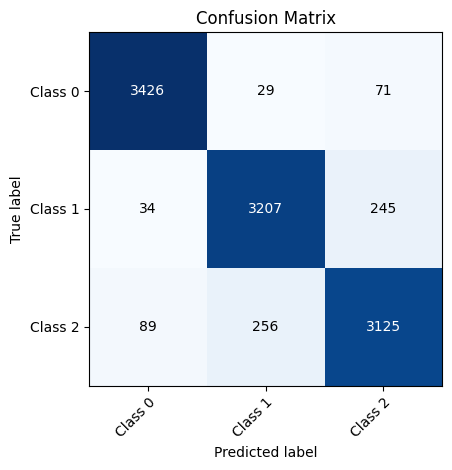

Model: Decision Trees
-------------------------------------
Model: k-Nearest Neighbors
Accuracy: 0.9527761877504293
Precision: 0.9528635299422952
Recall: 0.9527761877504293
F1 Score: 0.9527655987552929
Confusion Matrix:
[[3482   15   29]
 [   9 3302  175]
 [  31  236 3203]]




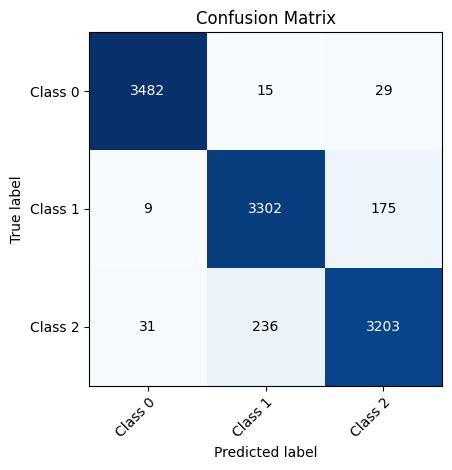

Model: k-Nearest Neighbors
-------------------------------------


In [ ]:
for model_name in model_names:
    train_and_evaluate_model(X_train, y_train, X_test, y_test, model_name)
    print("Model:", model_name)
    print("-------------------------------------")

# Zcr

In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

def mix_audio(main_folder_path, file_path_ambient, duration, SR, Limit):
    audio_data = []
    zcr_data = []
    labels = []

    segment_sr_required = duration * SR

    no_of_drone_samples = 0
    no_of_swarm_drone_samples = 0
    no_of_aircraft_samples = 0

    for file_name in os.listdir(main_folder_path):
        if 'drone'.lower() in file_name.lower():
            flag = 0
        elif 'swarm'.lower() in file_name.lower():
            flag = 1
        elif 'aircraft'.lower() in file_name.lower():
            flag = 2
        else:
            continue

        if file_name.endswith('.wav') or file_name.endswith('.WAV') or file_name.endswith('.mp3'):
            file_path = os.path.join(main_folder_path, file_name)
            signal_data, sr = librosa.load(file_path, sr=None, duration=1747)
            signal_data = signal_data / np.max(np.abs(signal_data))
            noise_data, sr_noise = librosa.load(file_path_ambient, sr=None, duration=2640)
            noise_data = noise_data / np.max(np.abs(noise_data))

            s = len(signal_data)
            n = len(noise_data)

            if n > s:
                noise_data = noise_data[0:s]
            elif s > n:
                w = s - n
                noise_data = np.concatenate((noise_data, noise_data[0:w]))
            else:
                pass

            N = int(len(signal_data) / segment_sr_required)

            for i in range(N):
                start = i * segment_sr_required
                end = start + segment_sr_required

                if end - start != SR:
                    continue

                segment = signal_data[start:end]
                start_noise = np.random.randint(0, N-1) * segment_sr_required
                end_noise = start_noise + segment_sr_required

                if end_noise - start_noise != SR:
                    continue

                noise = noise_data[start_noise:end_noise]

                rms_signal = np.mean(np.square(segment))
                rms_noise = np.mean(np.square(noise))

                dbset = [-25, -20, -15, -10, -5, 0, 5, 10, 15, 20]

                for j in range(len(dbset)):
                    rms_signal_req_to_increase = rms_noise / (10 ** (-dbset[j] / 10))
                    scaling_factor = np.sqrt(rms_signal_req_to_increase / rms_signal)
                    adjusted_audio_signal = segment * scaling_factor

                    adjusted_audio_signal += noise

                    audio_data.append(adjusted_audio_signal)

                    zcr = librosa.feature.zero_crossing_rate(y=adjusted_audio_signal, frame_length=SR, hop_length=SR)
                    mean_zcr = np.mean(zcr, axis=-1)

                    zcr_data.append(mean_zcr)
                    labels.append(flag)

                    if flag == 0:
                        no_of_drone_samples += 1
                    elif flag == 1:
                        no_of_swarm_drone_samples += 1
                    elif flag == 2:
                        no_of_aircraft_samples += 1

    zcr_data = np.array(zcr_data)
    labels = tf.keras.utils.to_categorical(labels, num_classes=3)

    mean_zcr = np.mean(zcr_data)
    std_zcr = np.std(zcr_data)
    normalized_zcr_data = (zcr_data - mean_zcr) / std_zcr

    print("Drone samples:", no_of_drone_samples,
          "\nSwarm Drone samples:", no_of_swarm_drone_samples,
          "\nAircraft samples:", no_of_aircraft_samples)

    return normalized_zcr_data, labels



In [ ]:
zcr_data, labels_zcr = mix_audio(dataset_dir, ambient_path, 1, 44100, 21000)


Drone samples: 17470 
Swarm Drone samples: 17470 
Aircraft samples: 17470


In [ ]:
# Convert one-hot encoded labels to 1D array
y_labels = np.argmax(labels_zcr, axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(zcr_data, y_labels, test_size=0.3, random_state=42)

# Create SVM classifiers with different kernels
classifiers = {
    'Linear': SVC(kernel='linear'),
    'Cubic': SVC(kernel='poly', degree=3),
    'Quadratic': SVC(kernel='poly', degree=2),
    'Gaussian': SVC(kernel='rbf'),
}

# Define class labels
class_labels = ['Drone', 'Swarm Drone', 'Aircraft']

# Train and evaluate each SVM classifier
for kernel_name, classifier in classifiers.items():
    # Train the classifier
    classifier.fit(X_train, y_train)

    # Predict labels for test set
    y_pred = classifier.predict(X_test)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate sensitivity, specificity, and class-wise accuracy
    sensitivity = []
    specificity = []
    class_accuracy = []
    for i in range(len(class_labels)):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - tp - fn - fp

        class_sensitivity = tp / (tp + fn)
        class_specificity = tn / (tn + fp)
        class_samples = np.sum(y_test == i)
        class_correct = tp
        class_acc = class_correct / class_samples

        sensitivity.append(class_sensitivity)
        specificity.append(class_specificity)
        class_accuracy.append(class_acc)

    # Print confusion matrix
    print(f'{kernel_name} kernel:')
    print('Confusion Matrix:')
    print(cm)
    print()

    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=class_labels)

    # Print classification report
    print('Classification Report:')
    print(report)
    print()

    # Print class-wise metrics
    print('Class-wise Metrics:')
    for i, label in enumerate(class_labels):
        print(f'{label}:')
        print(f'  Sensitivity: {sensitivity[i]}')
        print(f'  Specificity: {specificity[i]}')
        print(f'  Accuracy: {class_accuracy[i]}')
        print()


Linear kernel:
Confusion Matrix:
[[2725 1031 1447]
 [1412  885 2995]
 [ 420 1031 3777]]

Classification Report:
              precision    recall  f1-score   support

       Drone       0.60      0.52      0.56      5203
 Swarm Drone       0.30      0.17      0.21      5292
    Aircraft       0.46      0.72      0.56      5228

    accuracy                           0.47     15723
   macro avg       0.45      0.47      0.44     15723
weighted avg       0.45      0.47      0.44     15723


Class-wise Metrics:
Drone:
  Sensitivity: 0.5237363059773208
  Specificity: 0.8258555133079848
  Accuracy: 0.5237363059773208

Swarm Drone:
  Sensitivity: 0.16723356009070295
  Specificity: 0.8023200076694469
  Accuracy: 0.16723356009070295

Aircraft:
  Sensitivity: 0.7224560061208876
  Specificity: 0.5767508337303477
  Accuracy: 0.7224560061208876

Cubic kernel:
Confusion Matrix:
[[1194 3666  343]
 [ 239 4163  890]
 [  63 3311 1854]]

Classification Report:
              precision    recall  f1-score

# psd

In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf

def mix_audio(main_folder_path, file_path_ambient, duration, SR, Limit):
    audio_data = []
    log_psd_data = []
    labels = []

    segment_sr_required = duration * SR

    no_of_drone_samples = 0
    no_of_swarm_drone_samples = 0
    no_of_aircraft_samples = 0

    for file_name in os.listdir(main_folder_path):
        if 'drone'.lower() in file_name.lower():
            flag = 0
        elif 'swarm'.lower() in file_name.lower():
            flag = 1
        elif 'aircraft'.lower() in file_name.lower():
            flag = 2
        else:
            continue

        if file_name.endswith('.wav') or file_name.endswith('.WAV') or file_name.endswith('.mp3'):
            file_path = os.path.join(main_folder_path, file_name)
            signal_data, sr = librosa.load(file_path, sr=None, duration=1747)
            signal_data = signal_data / np.max(np.abs(signal_data))
            noise_data, sr_noise = librosa.load(file_path_ambient, sr=None, duration=2640)
            noise_data = noise_data / np.max(np.abs(noise_data))

            s = len(signal_data)
            n = len(noise_data)

            if n > s:
                noise_data = noise_data[0:s]
            elif s > n:
                w = s - n
                noise_data = np.concatenate((noise_data, noise_data[0:w]))
            else:
                pass

            N = int(len(signal_data) / segment_sr_required)

            for i in range(N):
                start = i * segment_sr_required
                end = start + segment_sr_required

                if end - start != SR:
                    continue

                segment = signal_data[start:end]
                start_noise = np.random.randint(0, N-1) * segment_sr_required
                end_noise = start_noise + segment_sr_required

                if end_noise - start_noise != SR:
                    continue

                noise = noise_data[start_noise:end_noise]

                rms_signal = np.mean(np.square(segment))
                rms_noise = np.mean(np.square(noise))

                dbset = [-25, -20, -15, -10, -5, 0, 5, 10, 15, 20]

                for j in range(len(dbset)):
                    rms_signal_req_to_increase = rms_noise / (10 ** (-dbset[j] / 10))
                    scaling_factor = np.sqrt(rms_signal_req_to_increase / rms_signal)
                    adjusted_audio_signal = segment * scaling_factor

                    adjusted_audio_signal += noise

                    audio_data.append(adjusted_audio_signal)

                    # Compute log PSD instead of MFCC
                    psd = np.abs(np.fft.fft(adjusted_audio_signal)) ** 2
                    log_psd = 10 * np.log10(psd)

                    log_psd_data.append(log_psd)
                    labels.append(flag)

                    if flag == 0:
                        no_of_drone_samples += 1
                    elif flag == 1:
                        no_of_swarm_drone_samples += 1
                    elif flag == 2:
                        no_of_aircraft_samples += 1

    log_psd_data = tf.keras.preprocessing.sequence.pad_sequences(log_psd_data)
    labels = np.asarray(labels)

    mean_log_psd = np.mean(log_psd_data)
    std_log_psd = np.std(log_psd_data)
    normalized_log_psd_data = (log_psd_data - mean_log_psd) / std_log_psd

    print("Drone samples:", no_of_drone_samples,
          "\nSwarm Drone samples:", no_of_swarm_drone_samples,
          "\nAircraft samples:", no_of_aircraft_samples)

    return normalized_log_psd_data, labels


In [ ]:
psd_data, labels = mix_audio(dataset_dir, ambient_path, 1, 44100, 21000)

Drone samples: 17470 
Swarm Drone samples: 17470 
Aircraft samples: 17470


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(psd_data, labels, test_size=0.3, random_state=42)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# Create an imputer to handle missing values
imputer = SimpleImputer(strategy='mean')

# Apply imputation to training data
X_train = imputer.fit_transform(X_train)

# Create SVM classifiers with different kernels
classifiers = {
    'Linear': SVC(kernel='linear'),
    'Cubic': SVC(kernel='poly', degree=3),
    'Quadratic': SVC(kernel='poly', degree=2),
    'Gaussian': SVC(kernel='rbf'),
}

# Define class labels
class_labels = ['Drone', 'Swarm Drone', 'Aircraft']

# Train and evaluate each SVM classifier
for kernel_name, classifier in classifiers.items():
    # Train the classifier
    classifier.fit(X_train, y_train)

    # Predict labels for test set
    y_pred = classifier.predict(X_test)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate sensitivity, specificity, and class-wise accuracy
    sensitivity = []
    specificity = []
    class_accuracy = []
    for i in range(len(class_labels)):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - tp - fn - fp

        class_sensitivity = tp / (tp + fn)
        class_specificity = tn / (tn + fp)
        class_samples = np.sum(y_test == i)
        class_correct = tp
        class_acc = class_correct / class_samples

        sensitivity.append(class_sensitivity)
        specificity.append(class_specificity)
        class_accuracy.append(class_acc)

    # Print confusion matrix
    print(f'{kernel_name} kernel:')
    print('Confusion Matrix:')
    print(cm)
    print()

    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=class_labels)

    # Print classification report
    print('Classification Report:')
    print(report)
    print()

    # Print class-wise metrics
    print('Class-wise Metrics:')
    for i, label in enumerate(class_labels):
        print(f'{label}:')
        print(f'  Sensitivity: {sensitivity[i]}')
        print(f'  Specificity: {specificity[i]}')
        print(f'  Accuracy: {class_accuracy[i]}')
        print()

Linear kernel:
Confusion Matrix:
[[5174   11   43]
 [   2 5111   90]
 [   2   69 5221]]

Classification Report:
              precision    recall  f1-score   support

       Drone       1.00      0.99      0.99      5228
 Swarm Drone       0.98      0.98      0.98      5203
    Aircraft       0.98      0.99      0.98      5292

    accuracy                           0.99     15723
   macro avg       0.99      0.99      0.99     15723
weighted avg       0.99      0.99      0.99     15723


Class-wise Metrics:
Drone:
  Sensitivity: 0.9896710022953328
  Specificity: 0.999618866126727
  Accuracy: 0.9896710022953328

Swarm Drone:
  Sensitivity: 0.9823178935229675
  Specificity: 0.9923954372623575
  Accuracy: 0.9823178935229675

Aircraft:
  Sensitivity: 0.986583522297808
  Specificity: 0.9872495446265938
  Accuracy: 0.986583522297808

Cubic kernel:
Confusion Matrix:
[[4988   90  150]
 [  50 4775  378]
 [  69  249 4974]]

Classification Report:
              precision    recall  f1-score   su

# Spectral Centroid

In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf

def mix_audio(main_folder_path, file_path_ambient, duration, SR, Limit):
    audio_data = []
    spec_centroid_data = []
    labels = []

    segment_sr_required = duration * SR

    no_of_drone_samples = 0
    no_of_swarm_drone_samples = 0
    no_of_aircraft_samples = 0

    for file_name in os.listdir(main_folder_path):
        if 'drone'.lower() in file_name.lower():
            flag = 0
        elif 'swarm'.lower() in file_name.lower():
            flag = 1
        elif 'aircraft'.lower() in file_name.lower():
            flag = 2
        else:
            continue

        if file_name.endswith('.wav') or file_name.endswith('.WAV') or file_name.endswith('.mp3'):
            file_path = os.path.join(main_folder_path, file_name)
            signal_data, sr = librosa.load(file_path, sr=44100, duration=1747)
            signal_data = signal_data / np.max(np.abs(signal_data))
            noise_data, sr_noise = librosa.load(file_path_ambient, sr=44100, duration=2640)
            noise_data = noise_data / np.max(np.abs(noise_data))

            s = len(signal_data)
            n = len(noise_data)

            if n > s:
                noise_data = noise_data[0:s]
            elif s > n:
                w = s - n
                noise_data = np.concatenate((noise_data, noise_data[0:w]))
            else:
                pass

            N = int(len(signal_data) / segment_sr_required)

            for i in range(N):
                start = i * segment_sr_required
                end = start + segment_sr_required

                if end - start != SR:
                    continue

                segment = signal_data[start:end]
                start_noise = np.random.randint(0, N-1) * segment_sr_required
                end_noise = start_noise + segment_sr_required

                if end_noise - start_noise != SR:
                    continue

                noise = noise_data[start_noise:end_noise]

                rms_signal = np.mean(np.square(segment))
                rms_noise = np.mean(np.square(noise))

                dbset = [-25, -20, -15, -10, -5, 0, 5, 10, 15, 20]

                for j in range(len(dbset)):
                    rms_signal_req_to_increase = rms_noise / (10 ** (-dbset[j] / 10))
                    scaling_factor = np.sqrt(rms_signal_req_to_increase / rms_signal)
                    adjusted_audio_signal = segment * scaling_factor

                    adjusted_audio_signal += noise

                    audio_data.append(adjusted_audio_signal)

                    spec_centroid = librosa.feature.spectral_centroid(y=adjusted_audio_signal, sr=SR)
                    log_spec_centroid = np.log10(spec_centroid)

                    spec_centroid_data.append(log_spec_centroid)
                    labels.append(flag)

                    if flag == 0:
                        no_of_drone_samples += 1
                    elif flag == 1:
                        no_of_swarm_drone_samples += 1
                    elif flag == 2:
                        no_of_aircraft_samples += 1

    spec_centroid_data = tf.keras.preprocessing.sequence.pad_sequences(spec_centroid_data)
    labels = tf.keras.utils.to_categorical(labels, num_classes=3)

    mean_spec_centroid = np.mean(spec_centroid_data)
    std_spec_centroid = np.std(spec_centroid_data)
    normalized_spec_centroid_data = (spec_centroid_data - mean_spec_centroid) / std_spec_centroid

    print("Drone samples:", no_of_drone_samples,
          "\nSwarm Drone samples:", no_of_swarm_drone_samples
          ,"\nAircraft samples:", no_of_aircraft_samples)

    return normalized_spec_centroid_data, labels


In [ ]:
normalized_spec_centroid_data, labels = mix_audio(dataset_dir, ambient_path, 1, 44100, 21000)

Drone samples: 17470 
Swarm Drone samples: 17470 
Aircraft samples: 17470


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import numpy as np

# Reshape normalized_spec_centroid_data to have 2 dimensions
X_train = normalized_spec_centroid_data.reshape(normalized_spec_centroid_data.shape[0], -1)

# Convert one-hot encoded labels to 1-dimensional array
y = np.argmax(labels, axis=1)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.3, random_state=42)

# Create an imputer to handle missing values
imputer = SimpleImputer(strategy='mean')

# Apply imputation to training data
X_train = imputer.fit_transform(X_train)

# Create SVM classifiers with different kernels
classifiers = {
    'Linear': SVC(kernel='linear'),
    'Cubic': SVC(kernel='poly', degree=3),
    'Quadratic': SVC(kernel='poly', degree=2),
    'Gaussian': SVC(kernel='rbf'),
}

# Define class labels
class_labels = ['Drone', 'Swarm Drone', 'Aircraft']

# Train and evaluate each SVM classifier
for kernel_name, classifier in classifiers.items():
    # Train the classifier
    classifier.fit(X_train, y_train)

    # Predict labels for test set
    y_pred = classifier.predict(X_test)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate sensitivity, specificity, and class-wise accuracy
    sensitivity = []
    specificity = []
    class_accuracy = []
    for i in range(len(class_labels)):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - tp - fn - fp

        class_sensitivity = tp / (tp + fn)
        class_specificity = tn / (tn + fp)
        class_samples = np.sum(y_test == i)
        class_correct = tp
        class_acc = class_correct / class_samples

        sensitivity.append(class_sensitivity)
        specificity.append(class_specificity)
        class_accuracy.append(class_acc)

    # Print confusion matrix
    print(f'{kernel_name} kernel:')
    print('Confusion Matrix:')
    print(cm)
    print()

    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=class_labels)

    # Print classification report
    print('Classification Report:')
    print(report)
    print()

    # Print class-wise metrics
    print('Class-wise Metrics:')
    for i, label in enumerate(class_labels):
        print(f'{label}:')
        print(f'  Sensitivity: {sensitivity[i]}')
        print(f'  Specificity: {specificity[i]}')
        print(f'  Accuracy: {class_accuracy[i]}')
        print()


Linear kernel:
Confusion Matrix:
[[ 877 4324    2]
 [   1 5218   73]
 [   2 4427  799]]

Classification Report:
              precision    recall  f1-score   support

       Drone       1.00      0.17      0.29      5203
 Swarm Drone       0.37      0.99      0.54      5292
    Aircraft       0.91      0.15      0.26      5228

    accuracy                           0.44     15723
   macro avg       0.76      0.44      0.36     15723
weighted avg       0.76      0.44      0.36     15723


Class-wise Metrics:
Drone:
  Sensitivity: 0.16855660196040745
  Specificity: 0.9997148288973384
  Accuracy: 0.16855660196040745

Swarm Drone:
  Sensitivity: 0.9860166288737717
  Specificity: 0.16105838366407824
  Accuracy: 0.9860166288737717

Aircraft:
  Sensitivity: 0.15283091048201988
  Specificity: 0.9928537398761315
  Accuracy: 0.15283091048201988

Cubic kernel:
Confusion Matrix:
[[ 786 4414    3]
 [   0 5232   60]
 [   0 4394  834]]

Classification Report:
              precision    recall  f1-sc